<a href="https://colab.research.google.com/github/BYFarag/Homelessness/blob/main/Bayan_Farag_DATA_3320_Homelessness_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The 2020 [point-in-time count](https://www.kingcounty.gov/elected/executive/constantine/news/release/2020/July/01-homeless-count.aspx) of people experiencing homelessness for Seattle/King County was 11,751. This represents a 5% increase over the 2019 count and reflects similar trend across many counties in the western U.S.. A step towards addressing homelessness is improving our understanding of the relationship between local housing market factors and homelessness. 

The U.S. Department of Housing and Urban Development (HUD) produced a report in 2019 [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) that describes a model-based approach to understanding of the relationship between local housing market factors and homelessness. Our project is motivated by the goals of the HUD study:

"To continue progressing toward the goals of ending and preventing homelessness, we must further our knowledge of the basic community-level determinants of homelessness. The primary objectives of this study are to (1) identify market factors that have established effects on homelessness, (2) construct and evaluate empirical models of community-level homelessness.."

We will investigate whether there are alternative modeling approaches that outperform the models described in the HUD report.


## Import libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

## The data

The [data](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/05b_analysis_file_update.csv) for this project are described in HUD's report [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) in the section titled DATA.

I will refer you to this section of the HUD report for a detailed description of the sources of the data and how they were processed.

The data dictionary [HUD TO3 - 05b Analysis File - Data Dictionary.csv](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv) contains descriptions of all variables in the data set.




## Load the data

In [94]:
df = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/homelessness/05b_analysis_file_update.csv')

In [95]:
dictionary = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv')

In [96]:
df.head()

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_rent75,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural
0,2010,AK-500,1113.0,118.0,1231.0,633.0,107.0,740.0,480.0,11.0,...,1,1,1,3,1,1,1,1,0,0
1,2011,AK-500,1082.0,141.0,1223.0,677.0,117.0,794.0,405.0,24.0,...,1,1,0,3,1,1,1,1,0,0
2,2012,AK-500,1097.0,50.0,1147.0,756.0,35.0,791.0,341.0,15.0,...,1,1,1,3,1,1,1,1,0,0
3,2013,AK-500,1070.0,52.0,1122.0,792.0,52.0,844.0,278.0,0.0,...,1,1,0,3,1,1,1,1,0,0
4,2014,AK-500,970.0,53.0,1023.0,688.0,48.0,736.0,282.0,5.0,...,1,1,1,3,1,1,1,1,0,0


## Explore the contents of the data set

Before starting we are going to ask some guiding questions...

What variable(s) do we want to predict?
* Rate of homelessness

What variables seem useful as predictors?
* Total Homelessness 
* Total Population 
* Total unsheltered 
* Number of evictions

Are any predictor variables redundant?
* There are a couple of redundant variables theres also some correlation between variables but that doesn't mean it is causation



### Explore the data sources

Down below we are going to explore the data & for the first part we are looking at the main sources from the dictionary

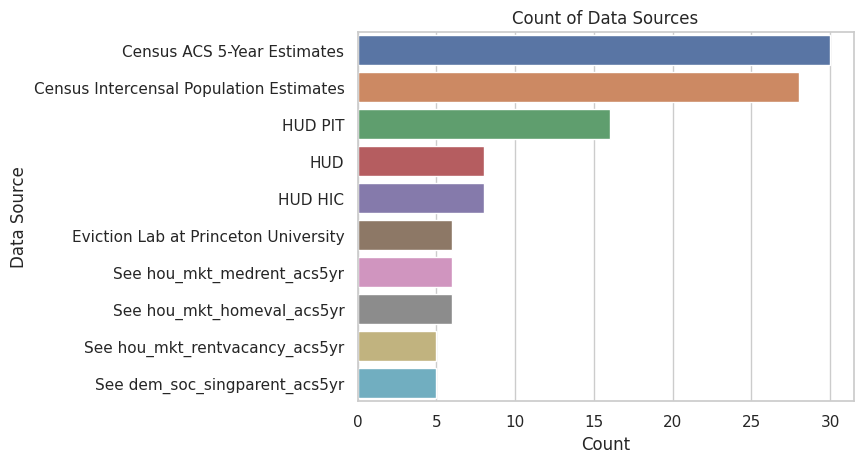

In [97]:
counts = dictionary['Source or Root Variable'].value_counts().head(10)
sns.barplot(x=counts.values, y=counts.index, orient = 'horizontal')
plt.xlabel('Count')
plt.ylabel('Data Source')
plt.title('Count of Data Sources')
plt.show()

This bar graph counts the different data sources described in "Source or Root Variable" in dictionary. It includes the 10 most common data sources. From this graph we can see that Census & HUB are the main sources. 


## Select relevant subsets of the data

Since there are many many variables we are going to pick the ones we want to focus on. Down below we are selecting them. 

In [98]:
columns_to_keep = ["year", "cocnumber", "rural", "suburban", "major_city",
  
                  "pit_tot_hless_pit_hud", "pit_tot_shelt_pit_hud", "pit_tot_unshelt_pit_hud","dem_pop_pop_census",
  
                  "fhfa_hpi_2009", "ln_hou_mkt_medrent_xt", "hou_mkt_utility_xt", "hou_mkt_burden_own_acs5yr_2017", "hou_mkt_burden_sev_rent_acs_2017", "hou_mkt_rentshare_acs5yr_2017", "hou_mkt_rentvacancy_xt", "hou_mkt_density_dummy", "hou_mkt_evict_count", "hou_mkt_ovrcrowd_acs5yr_2017", "major_city", "suburban",
           
                  "econ_labor_unemp_rate_BLS", "econ_labor_incineq_acs5yr_2017", "econ_labor_pov_pop_census_share",
           
                  "hou_pol_hudunit_psh_hud_share", "hou_pol_occhudunit_psh_hud", "hou_mkt_homeage1940_xt",
           
                  "dem_soc_black_census", "dem_soc_hispanic_census", "dem_soc_asian_census", "dem_soc_pacific_census", "dem_pop_child_census", "dem_pop_senior_census", "dem_pop_female_census", "dem_pop_mig_census", "d_dem_pop_mig_census_share", "dem_soc_singadult_xt", "dem_soc_singparent_xt", "dem_soc_vet_xt", "dem_soc_ed_lessbach_xt", "dem_health_cost_dart", "dem_health_excesdrink_chr",
           
                  "env_wea_avgtemp_noaa", "env_wea_avgtemp_summer_noaa", "env_wea_precip_noaa", "env_wea_precip_annual_noaa"]
    

In [99]:
df = df[columns_to_keep]

Great now we are going to look at what we now have selected/decided to keep

In [100]:
df.head()

,year,cocnumber,rural,suburban,major_city,pit_tot_hless_pit_hud,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,dem_pop_pop_census,fhfa_hpi_2009,...,dem_soc_singadult_xt,dem_soc_singparent_xt,dem_soc_vet_xt,dem_soc_ed_lessbach_xt,dem_health_cost_dart,dem_health_excesdrink_chr,env_wea_avgtemp_noaa,env_wea_avgtemp_summer_noaa,env_wea_precip_noaa,env_wea_precip_annual_noaa
0,2010,AK-500,0,0,1,1231.0,1113.0,118.0,285194,0.000000,...,NaN,NaN,NaN,NaN,7.78885,NaN,18.400000,56.599998,0.68,12.560000
1,2011,AK-500,0,0,1,1223.0,1082.0,141.0,293370,0.009359,...,24.832815,21.77351,17.23423,66.952057,7.85001,NaN,18.799999,55.799999,0.52,15.560000
2,2012,AK-500,0,0,1,1147.0,1097.0,50.0,296291,-0.049137,...,NaN,NaN,NaN,NaN,7.90594,NaN,2.900000,55.900002,1.17,16.459999
3,2013,AK-500,0,0,1,1122.0,1070.0,52.0,298520,-0.255042,...,24.832815,21.77351,17.23423,66.952057,7.83198,NaN,23.299999,56.000000,1.10,20.270000
4,2014,AK-500,0,0,1,1023.0,970.0,53.0,301081,3.170481,...,NaN,NaN,NaN,NaN,7.95718,NaN,30.299999,60.099998,1.52,24.010000


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              3008 non-null   int64  
 1   cocnumber                         3008 non-null   object 
 2   rural                             3008 non-null   int64  
 3   suburban                          3008 non-null   int64  
 4   major_city                        3008 non-null   int64  
 5   pit_tot_hless_pit_hud             2994 non-null   float64
 6   pit_tot_shelt_pit_hud             2994 non-null   float64
 7   pit_tot_unshelt_pit_hud           2994 non-null   float64
 8   dem_pop_pop_census                3008 non-null   int64  
 9   fhfa_hpi_2009                     3008 non-null   float64
 10  ln_hou_mkt_medrent_xt             1504 non-null   float64
 11  hou_mkt_utility_xt                1504 non-null   float64
 12  hou_mk

The next step is to take a look at the dictionary and see what 

In [102]:
dictionary_small = dictionary[dictionary['Variable'].isin(columns_to_keep)]

In [103]:
dictionary_small

,Associated Domain,Variable,Variable Label,Derived,Source or Root Variable,Table Name(s)
0,Identifier,year,year,No,NaN,NaN
1,Identifier,cocnumber,continuum of care number,No,HUD,NaN
2,Outcome,pit_tot_shelt_pit_hud,total sheltered - HUD PIT,No,HUD PIT,NaN
3,Outcome,pit_tot_unshelt_pit_hud,total unsheltered - HUD PIT,No,HUD PIT,NaN
4,Outcome,pit_tot_hless_pit_hud,total homeless - HUD PIT,No,HUD PIT,NaN
32,Demographic,dem_pop_pop_census,"total population, intercensal estimate",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
34,Demographic,dem_pop_female_census,"total female population, intercensal estimate",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
35,Demographic,dem_pop_child_census,"total population ages 0-19, intercensal estimate",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
37,Demographic,dem_pop_senior_census,"total population ages 65 or older, intercensal...",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
39,Demographic,dem_soc_black_census,"total black alone (non-hispanic) population, i...",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."


Now we want to see how many variables of each Associated Domain are in the smaller data set?

Text(0.5, 1.0, 'Associated Domains')

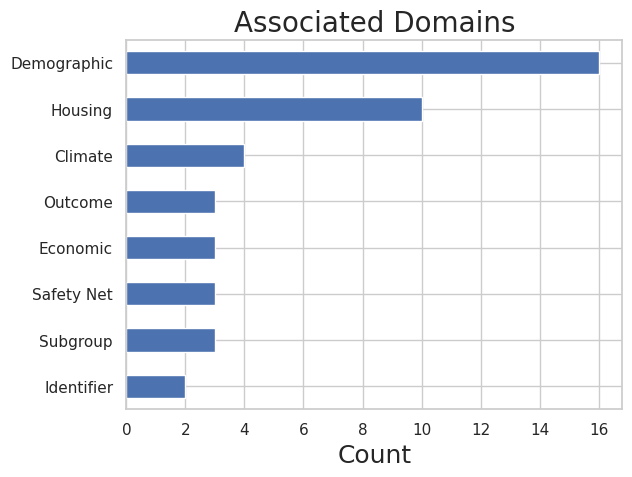

In [104]:
dictionary_small['Associated Domain'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()

plt.xlabel('Count', fontsize=18)
plt.title('Associated Domains', fontsize=20)

Now we are going to check which sources are in the smaller data set. 

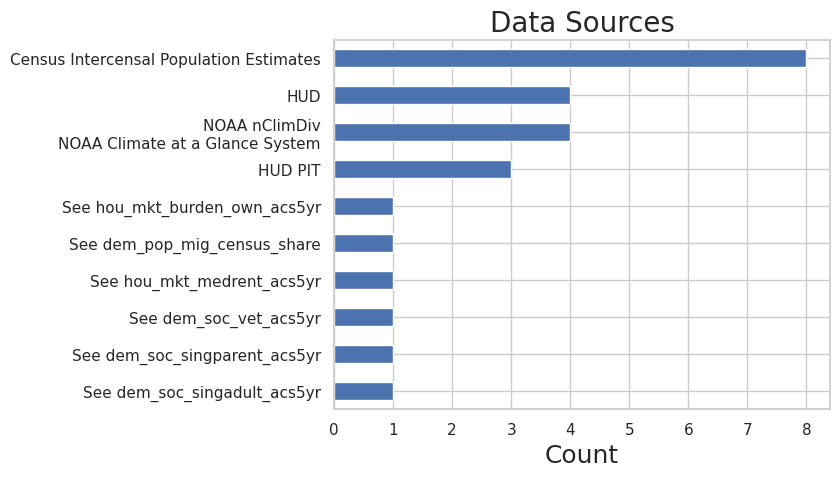

In [105]:
dictionary_small['Source or Root Variable'].value_counts().head(10).plot(kind='barh')
plt.gca().invert_yaxis()

plt.xlabel('Count', fontsize=18)
plt.title('Data Sources', fontsize=20);

## Are the data suitable for answering the question?

Before moving forward we want to ask if this data is suitable for answering the question? 

In [106]:
df.columns

Index(['year', 'cocnumber', 'rural', 'suburban', 'major_city',
       'pit_tot_hless_pit_hud', 'pit_tot_shelt_pit_hud',
       'pit_tot_unshelt_pit_hud', 'dem_pop_pop_census', 'fhfa_hpi_2009',
       'ln_hou_mkt_medrent_xt', 'hou_mkt_utility_xt',
       'hou_mkt_burden_own_acs5yr_2017', 'hou_mkt_burden_sev_rent_acs_2017',
       'hou_mkt_rentshare_acs5yr_2017', 'hou_mkt_rentvacancy_xt',
       'hou_mkt_density_dummy', 'hou_mkt_evict_count',
       'hou_mkt_ovrcrowd_acs5yr_2017', 'major_city', 'suburban',
       'econ_labor_unemp_rate_BLS', 'econ_labor_incineq_acs5yr_2017',
       'econ_labor_pov_pop_census_share', 'hou_pol_hudunit_psh_hud_share',
       'hou_pol_occhudunit_psh_hud', 'hou_mkt_homeage1940_xt',
       'dem_soc_black_census', 'dem_soc_hispanic_census',
       'dem_soc_asian_census', 'dem_soc_pacific_census',
       'dem_pop_child_census', 'dem_pop_senior_census',
       'dem_pop_female_census', 'dem_pop_mig_census',
       'd_dem_pop_mig_census_share', 'dem_soc_singadult_x

<ipython-input-107-742161715af1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.dropna().corr(), vmin=-1, vmax=1)


<Axes: >

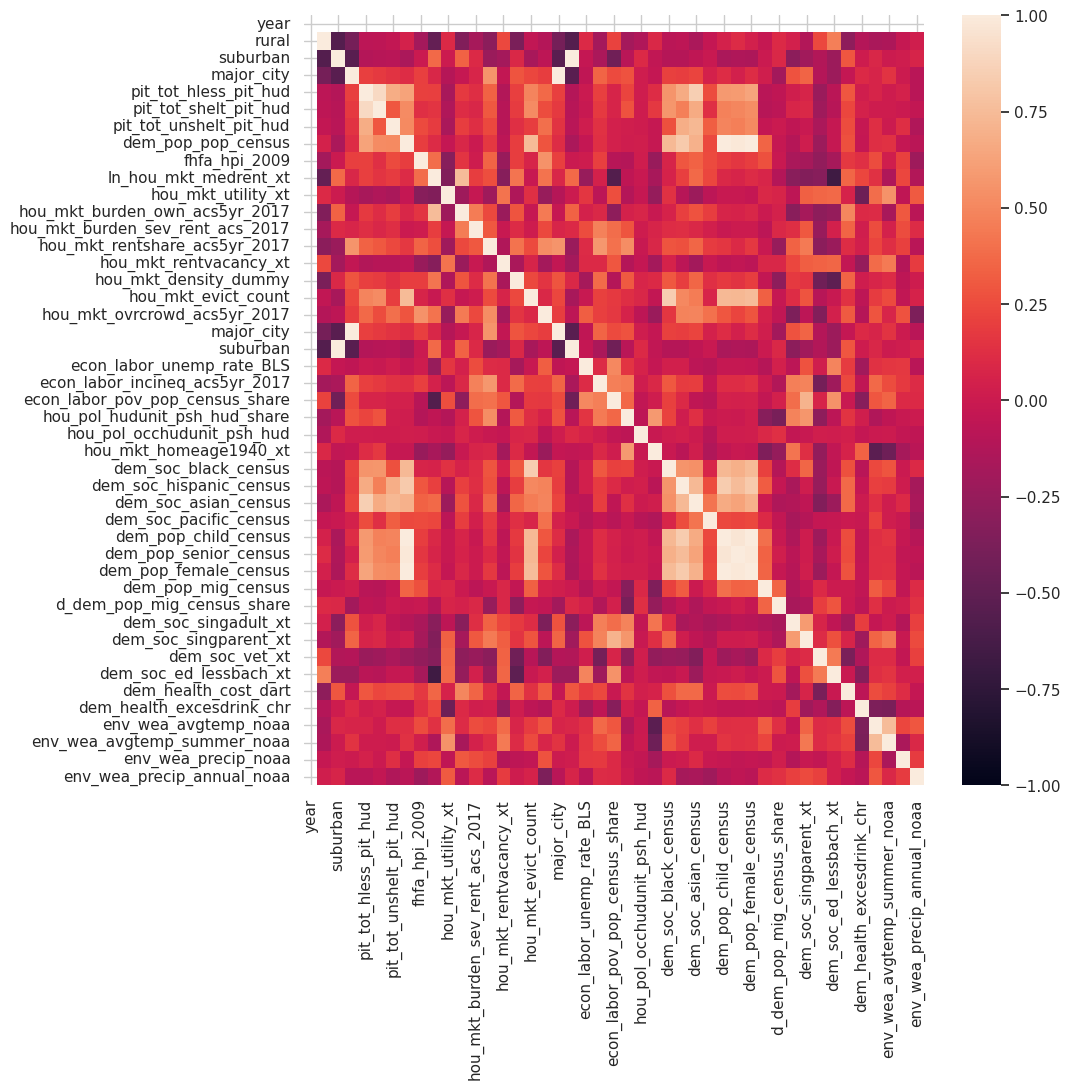

In [107]:
plt.figure(figsize=(10,10))
sns.heatmap(df.dropna().corr(), vmin=-1, vmax=1)

By analyzing the heatmap, we can observe meaningful relationships within the dataset, indicating its suitability for addressing the specific question we aim to investigate.

## Rename columns

Since the names in the orginal data set are a little hard to read we are going to rename them so they are easier to read & follow the proper notations

In [108]:
df = df.rename(columns = {"cocnumber":"coc_number",
  
                          "pit_tot_hless_pit_hud":"total_homeless", 
                          "pit_tot_shelt_pit_hud":"total_sheltered", 
                          "pit_tot_unshelt_pit_hud":"total_unsheltered",
                          "dem_pop_pop_census":"total_population",
  
                          "fhfa_hpi_2009":"house_price_index_2009", 
                          "ln_hou_mkt_medrent_xt":"log_median_rent", 
                          "hou_mkt_utility_xt":"utility_costs", 
                          "hou_mkt_burden_own_acs5yr_2017":"percentage_owners_cost_burden_2016", 
                          "hou_mkt_burden_sev_rent_acs_2017":"percentage_renters_severe_cost_burden_2016", 
                          "hou_mkt_rentshare_acs5yr_2017":"share_renters_2016", 
                          "hou_mkt_rentvacancy_xt":"rental_vacancy_rate", 
                          "hou_mkt_density_dummy":"high_housing_density", 
                          "hou_mkt_evict_count":"number_eviction", 
                          "hou_mkt_ovrcrowd_acs5yr_2017":"share_overcrowded_units_2016", 
                          "major_city":"city_or_urban", 
           
                          "econ_labor_unemp_rate_BLS":"rate_unemployment", 
                          "econ_labor_incineq_acs5yr_2017":"gini_coefficient_2016", 
                          "econ_labor_pov_pop_census_share":"poverty_rate",
           
                          "hou_pol_hudunit_psh_hud_share":"share_HUD_units", 
                          "hou_pol_occhudunit_psh_hud":"HUD_unit_occupancy_rate", 
                          "hou_mkt_homeage1940_xt":"share_built_before_1940",
           
                          "dem_soc_black_census":"total_black", 
                          "dem_soc_hispanic_census":"total_latino_hispanic", 
                          "dem_soc_asian_census":"total_asian", 
                          "dem_soc_pacific_census":"total_pacific_islander", 
                          "dem_pop_child_census":"total_population_0_19", 
                          "dem_pop_senior_census":"total_population_65_plus", 
                          "dem_pop_female_census":"total_female_population", 
                          "dem_pop_mig_census":"net_migration", 
                          "d_dem_pop_mig_census_share":"migration_4_year_change", 
                          "dem_soc_singadult_xt":"proportion_one_person_households", 
                          "dem_soc_singparent_xt":"share_under_18_with_single_parent", 
                          "dem_soc_vet_xt":"share_veteran_status", 
                          "dem_soc_ed_lessbach_xt":"share_no_bachelors", 
                          "dem_health_cost_dart":"medicare_reimbursements_per_enrollee", 
                          "dem_health_excesdrink_chr":"percentage_excessive_drinking",
           
                          "env_wea_avgtemp_noaa":"average_Jan_temperature", 
                          "env_wea_avgtemp_summer_noaa":"average_summer_temperature", 
                          "env_wea_precip_noaa":"total_Jan_precipitation", 
                          "env_wea_precip_annual_noaa":"total_annual_precipitation"})

Checking after renaming 

In [109]:
df.head(25)

,year,coc_number,rural,suburban,city_or_urban,total_homeless,total_sheltered,total_unsheltered,total_population,house_price_index_2009,...,proportion_one_person_households,share_under_18_with_single_parent,share_veteran_status,share_no_bachelors,medicare_reimbursements_per_enrollee,percentage_excessive_drinking,average_Jan_temperature,average_summer_temperature,total_Jan_precipitation,total_annual_precipitation
0,2010,AK-500,0,0,1,1231.0,1113.0,118.0,285194,0.000000,...,NaN,NaN,NaN,NaN,7.788850,NaN,18.400000,56.599998,0.680000,12.560000
1,2011,AK-500,0,0,1,1223.0,1082.0,141.0,293370,0.009359,...,24.832815,21.773510,17.234230,66.952057,7.850010,NaN,18.799999,55.799999,0.520000,15.560000
2,2012,AK-500,0,0,1,1147.0,1097.0,50.0,296291,-0.049137,...,NaN,NaN,NaN,NaN,7.905940,NaN,2.900000,55.900002,1.170000,16.459999
3,2013,AK-500,0,0,1,1122.0,1070.0,52.0,298520,-0.255042,...,24.832815,21.773510,17.234230,66.952057,7.831980,NaN,23.299999,56.000000,1.100000,20.270000
4,2014,AK-500,0,0,1,1023.0,970.0,53.0,301081,3.170481,...,NaN,NaN,NaN,NaN,7.957180,NaN,30.299999,60.099998,1.520000,24.010000
5,2015,AK-500,0,0,1,1208.0,1029.0,179.0,300296,7.330713,...,25.046440,23.379078,14.535126,65.634148,8.267290,NaN,20.500000,58.000000,0.350000,18.320000
6,2016,AK-500,0,0,1,1105.0,865.0,240.0,298018,10.091722,...,NaN,NaN,NaN,NaN,8.394480,NaN,27.200001,60.200001,0.280000,19.000000
7,2017,AK-500,0,0,1,1128.0,973.0,155.0,297376,11.743647,...,25.046440,23.379078,14.535126,65.634148,8.751520,0.193317,13.800000,60.799999,1.710000,16.500000
8,2010,AK-501,1,0,0,632.0,558.0,74.0,409496,0.000000,...,NaN,NaN,NaN,NaN,8.706042,NaN,18.400000,56.599998,0.680000,12.560000
9,2011,AK-501,1,0,0,905.0,678.0,227.0,420645,-1.004349,...,24.431116,20.316971,15.812447,76.472336,9.000302,NaN,18.799999,55.799999,0.520000,15.560000


## Quality Control

Now we are going to check for out-of-range values or values that do not match what we want to analyze. Either set values to `NaN` or remove the observations, as appropriate.





In [110]:
df.agg(['min','max']).T

,min,max
year,2010,2017
coc_number,AK-500,WY-500
rural,0,1
suburban,0,1
city_or_urban,0,1
total_homeless,7.0,76501.0
total_sheltered,3.0,72565.0
total_unsheltered,0.0,42828.0
total_population,29344,11058958
house_price_index_2009,-26.497087,63.864007


## Identify and deal with missing values

Here we are going to determine whether there are missing values in the data set even after focusing on the relevant subset of the data.

<Axes: >

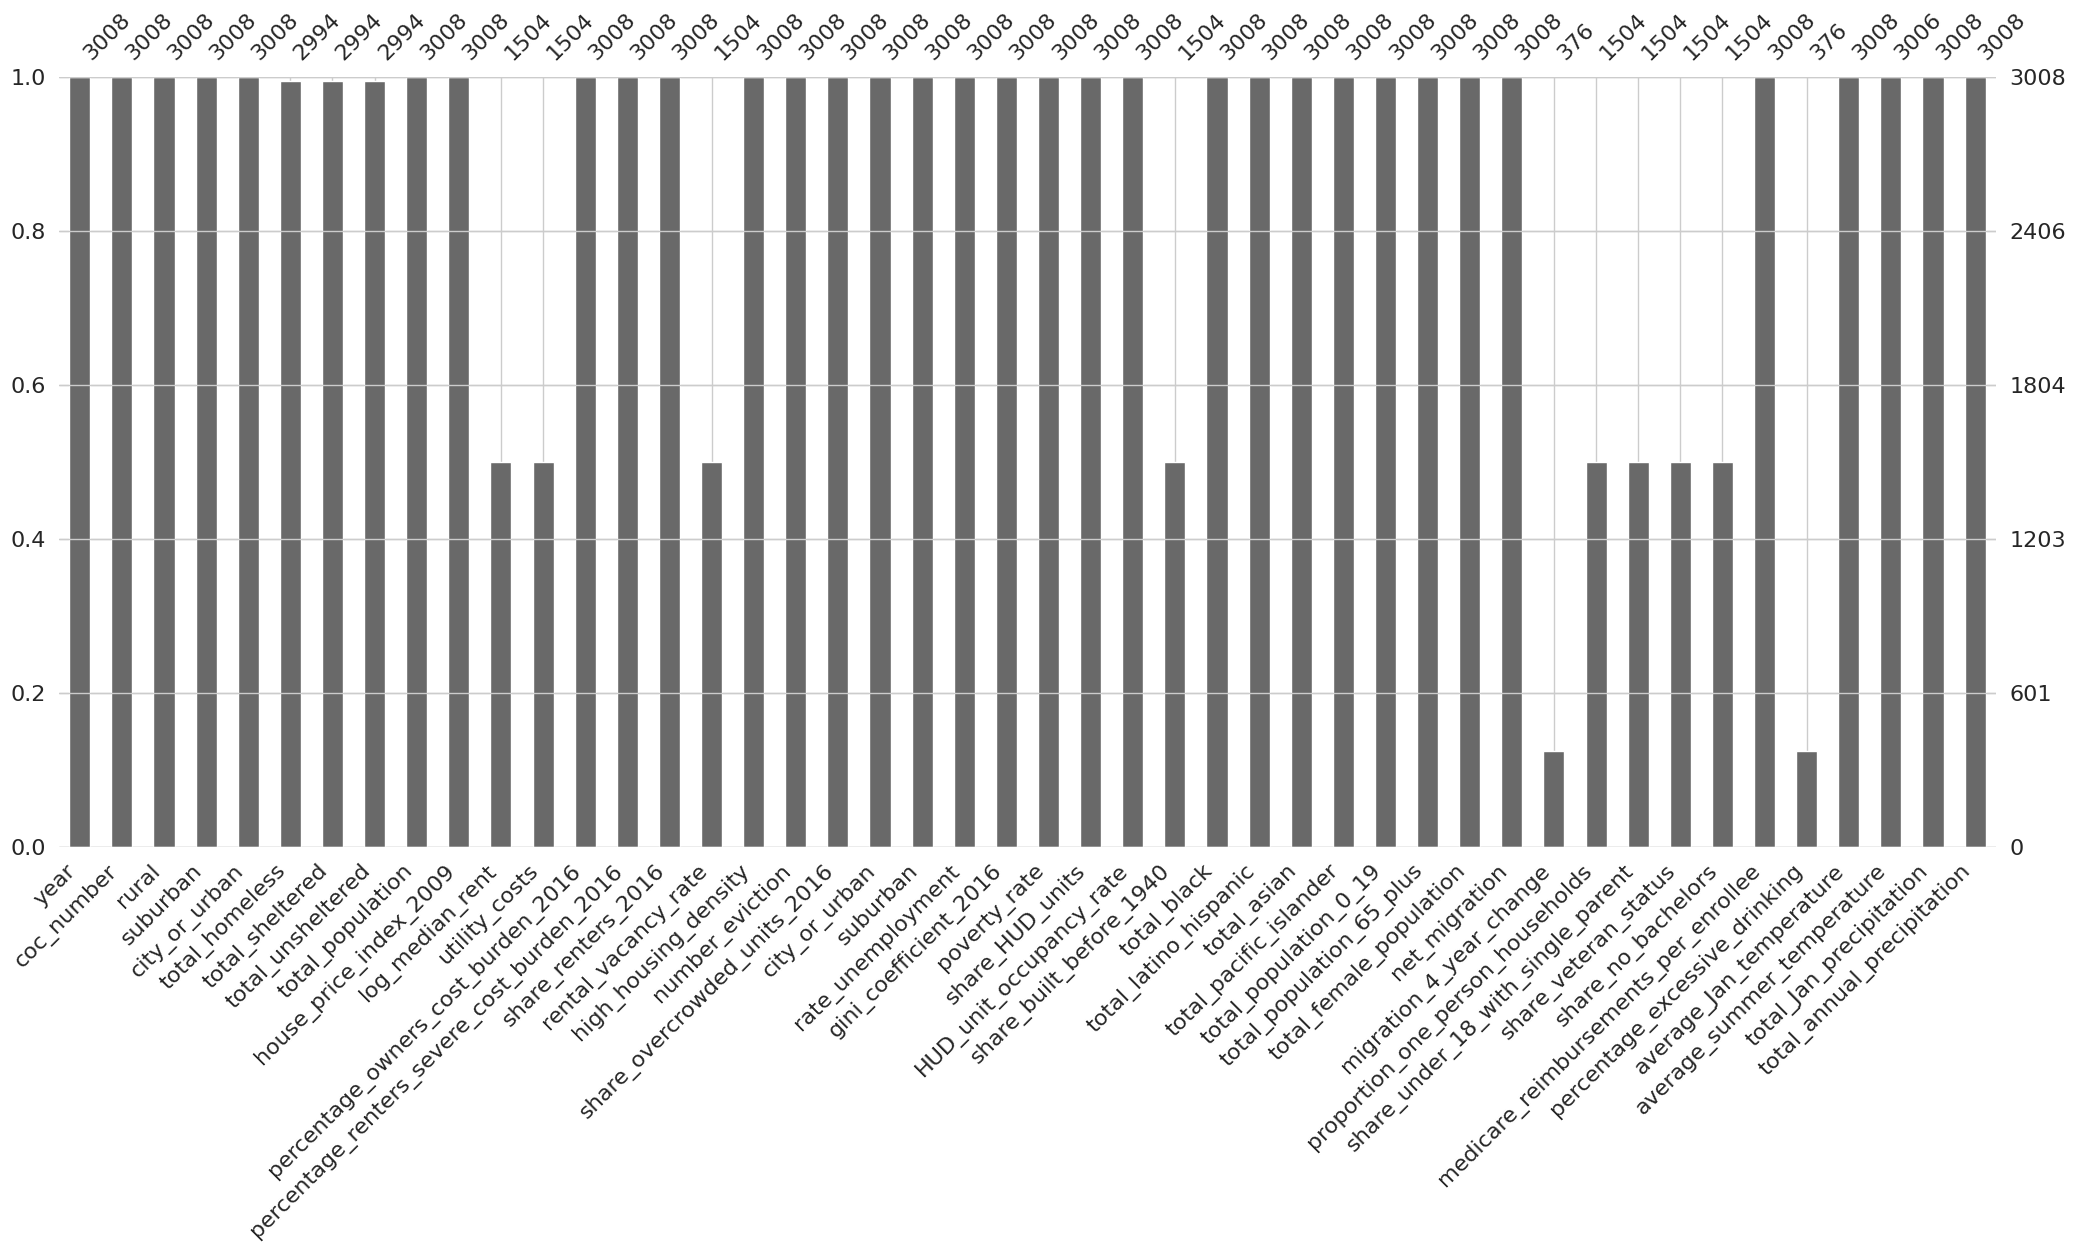

In [111]:
msno.bar(df)

There is some missing points and since we want to predict the number of people experiencing homelessness. We will remove the rows where those numbers are missing. 

In [112]:
df = df[df['total_homeless'].isna() == False]

In [113]:
df.isna().sum()

year                                             0
coc_number                                       0
rural                                            0
suburban                                         0
city_or_urban                                    0
total_homeless                                   0
total_sheltered                                  0
total_unsheltered                                0
total_population                                 0
house_price_index_2009                           0
log_median_rent                               1495
utility_costs                                 1495
percentage_owners_cost_burden_2016               0
percentage_renters_severe_cost_burden_2016       0
share_renters_2016                               0
rental_vacancy_rate                           1495
high_housing_density                             0
number_eviction                                  0
share_overcrowded_units_2016                     0
city_or_urban                  

Above we can tell there are a couple missing points for variables 
* log_median_rent 
* utility_costs 
* rental_vacancy_rate  
* share_built_before_1940 
* migration_4_year_change
* proportion_one_person_households 
* share_under_18_with_single_parent 
* share_veteran_status
* share_no_bachelors  
* percentage_excessive_drinking          


For that we will produce a scatter plot of the variables that are missing many values vs. time to see if data are missing from particular years.

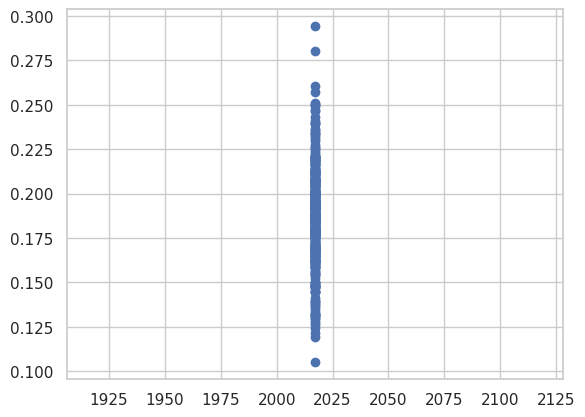

In [114]:
plt.plot(df['year'], df['percentage_excessive_drinking'], 'o'); 

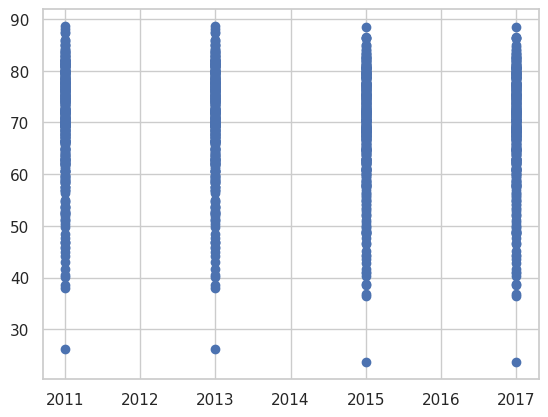

In [115]:
plt.plot(df['year'], df['share_no_bachelors'], 'o'); 

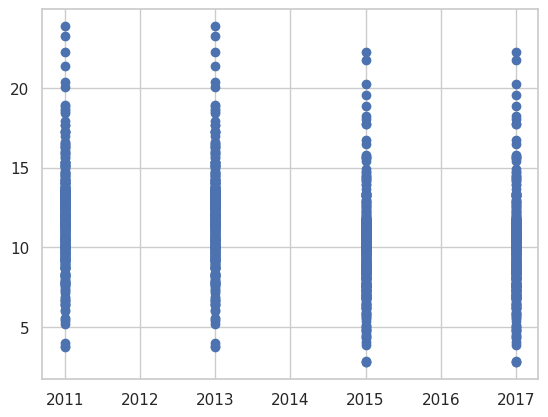

In [116]:
plt.plot(df['year'], df['share_veteran_status'], 'o'); 

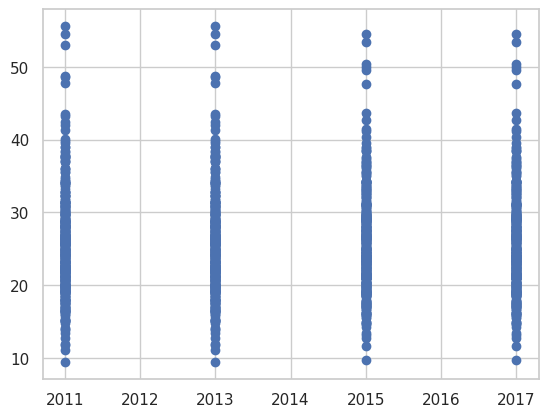

In [117]:
plt.plot(df['year'], df['share_under_18_with_single_parent'], 'o'); 

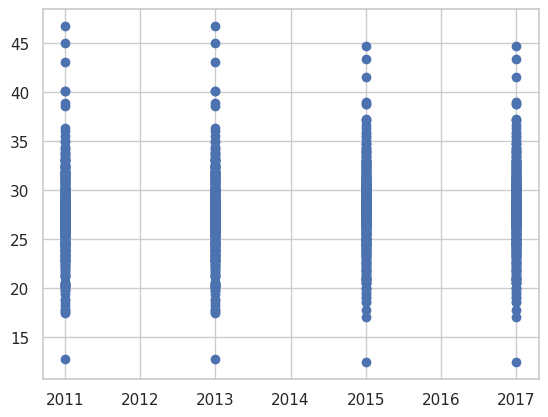

In [118]:
plt.plot(df['year'], df['proportion_one_person_households'], 'o'); 

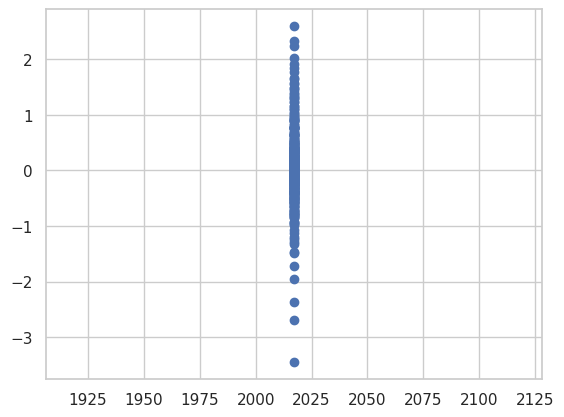

In [119]:
plt.plot(df['year'], df['migration_4_year_change'], 'o'); 

The only year all variables have in common is 2017 so in that case we will focus on that

In [120]:
df = df[df['year'] == 2017]

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 7 to 3007
Data columns (total 46 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   rural                                       374 non-null    int64  
 3   suburban                                    374 non-null    int64  
 4   city_or_urban                               374 non-null    int64  
 5   total_homeless                              374 non-null    float64
 6   total_sheltered                             374 non-null    float64
 7   total_unsheltered                           374 non-null    float64
 8   total_population                            374 non-null    int64  
 9   house_price_index_2009                      374 non-null    float64
 10  log_median_re

Now when we check info there are 374 entries and each one has 374 .. we can also make sure with isna().sum()

In [122]:
df.isna().sum()

year                                          0
coc_number                                    0
rural                                         0
suburban                                      0
city_or_urban                                 0
total_homeless                                0
total_sheltered                               0
total_unsheltered                             0
total_population                              0
house_price_index_2009                        0
log_median_rent                               0
utility_costs                                 0
percentage_owners_cost_burden_2016            0
percentage_renters_severe_cost_burden_2016    0
share_renters_2016                            0
rental_vacancy_rate                           0
high_housing_density                          0
number_eviction                               0
share_overcrowded_units_2016                  0
city_or_urban                                 0
suburban                                

## Create relevant derived variables as new columns

We may already know that we want to process the data to create new variables from the existing variables. However, we often start analyzing the data and realize that it is useful to create new variables derived from the existing variables. Or, we might not create any new columns. It is fine to return to modify this step after exploring the data further.

Because of that we want to create some new variables rate_homeless, rate_sheltered, and rate_unsheltered in the data frame df_2017 that are the counts per 10,000 people in the population. We will do this by taking the (total / population) for each one respectively



In [123]:
df['rate_homeless'] = df['total_homeless']/(df['total_population']/10_000)
df['rate_sheltered'] = df['total_sheltered']/(df['total_population']/10_000)
df['rate_unsheltered'] = df['total_unsheltered']/(df['total_population']/10_000)

<ipython-input-123-87b6e30b3656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_homeless'] = df['total_homeless']/(df['total_population']/10_000)
<ipython-input-123-87b6e30b3656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_sheltered'] = df['total_sheltered']/(df['total_population']/10_000)
<ipython-input-123-87b6e30b3656>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

We also want to change race, gender and age into percetanges rather than totals

In [124]:
df['percent_black'] = df['total_black'] / df['total_population']
df['percent_latino_hispanic'] = df['total_latino_hispanic'] / df['total_population']
df['percent_asian'] = df['total_asian'] / df['total_population']
df['percent_pacific_islander'] = df['total_pacific_islander'] / df['total_population']
df['percent_population_0_19'] = df['total_population_0_19'] / df['total_population']
df['percent_population_65_plus'] = df['total_population_65_plus'] / df['total_population']
df['percent_female_population'] = df['total_female_population'] / df['total_population']

<ipython-input-124-bafbd3333d2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent_black'] = df['total_black'] / df['total_population']
<ipython-input-124-bafbd3333d2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent_latino_hispanic'] = df['total_latino_hispanic'] / df['total_population']
<ipython-input-124-bafbd3333d2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Now that the file is cleaned we can export it as a CSV

## Export the clean .csv file

Exporting the clean data set

In [125]:
from google.colab import files

df.to_csv('df.csv', encoding = 'utf-8-sig', index=False) 
files.download('df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>